# 🎹 Legato Local Transcription Notebook

This notebook runs Basic Pitch locally using ONNX backend to transcribe piano audio into MIDI and extract note info.

✅ No Colab restarts
✅ Compatible with numpy 1.24.4
✅ Works offline

In [ ]:
# 📦 Prerequisites (install in terminal):
#python -m pip install --upgrade pip setuptools wheel
#pip install numpy==1.24.4 basic-pitch[onnx]==0.4.0 pretty_midi librosa soundfile


In [20]:
from basic_pitch.inference import predict_and_save
from basic_pitch import ICASSP_2022_MODEL_PATH
from pathlib import Path
import os

audio_path = r"C:\Users\thegr\Downloads\pianic\test_interleaved.wav"
output_dir = r"C:\Users\thegr\Downloads\pianic\output2"
os.makedirs(output_dir, exist_ok=True)

predict_and_save(
    [audio_path],
    output_dir,
    True,   # save_midi
    False,  # sonify_midi
    False,  # save_model_outputs
    False,  # save_notes
    ICASSP_2022_MODEL_PATH  # <--- FIXED: full ONNX model path
)




Predicting MIDI for C:\Users\thegr\Downloads\pianic\test_interleaved.wav...


  Creating midi...
  💅 Saved to C:\Users\thegr\Downloads\pianic\output2\test_interleaved_basic_pitch.mid


In [21]:
# 🎼 Parse MIDI to DataFrame
import pretty_midi
import pandas as pd
from pathlib import Path
midi_file = os.path.join(output_dir, Path(audio_path).stem + "_basic_pitch.mid")
midi = pretty_midi.PrettyMIDI(midi_file)

notes = []
for inst in midi.instruments:
    for n in inst.notes:
        notes.append({
            "pitch": n.pitch,
            "start": round(n.start, 3),
            "end": round(n.end, 3),
            "duration": round(n.end - n.start, 3),
            "velocity": n.velocity,
            "hand": "left" if n.pitch < 60 else "right"
        })

df = pd.DataFrame(notes)
df.head()

,pitch,start,end,duration,velocity,hand
0,48,0.023,0.384,0.361,59,left
1,60,0.209,0.407,0.198,63,right
2,50,0.639,0.814,0.175,53,left
3,48,0.384,0.825,0.441,68,left
4,50,0.825,1.218,0.393,55,left


In [23]:
import pretty_midi

df["note_name"] = df["pitch"].apply(pretty_midi.note_number_to_name)
df[["pitch", "note_name", "start", "end", "hand"]].head()


,pitch,note_name,start,end,hand
0,48,C3,0.023,0.384,left
1,60,C4,0.209,0.407,right
2,50,D3,0.639,0.814,left
3,48,C3,0.384,0.825,left
4,50,D3,0.825,1.218,left


In [24]:
def highlight_chords(df):
    df_sorted = df.sort_values(by="start").reset_index(drop=True)
    df_sorted["is_chord"] = False

    for i in range(1, len(df_sorted)):
        if abs(df_sorted.loc[i, "start"] - df_sorted.loc[i - 1, "start"]) < 0.05:
            df_sorted.loc[i, "is_chord"] = True
            df_sorted.loc[i - 1, "is_chord"] = True

    return df_sorted

df = highlight_chords(df)


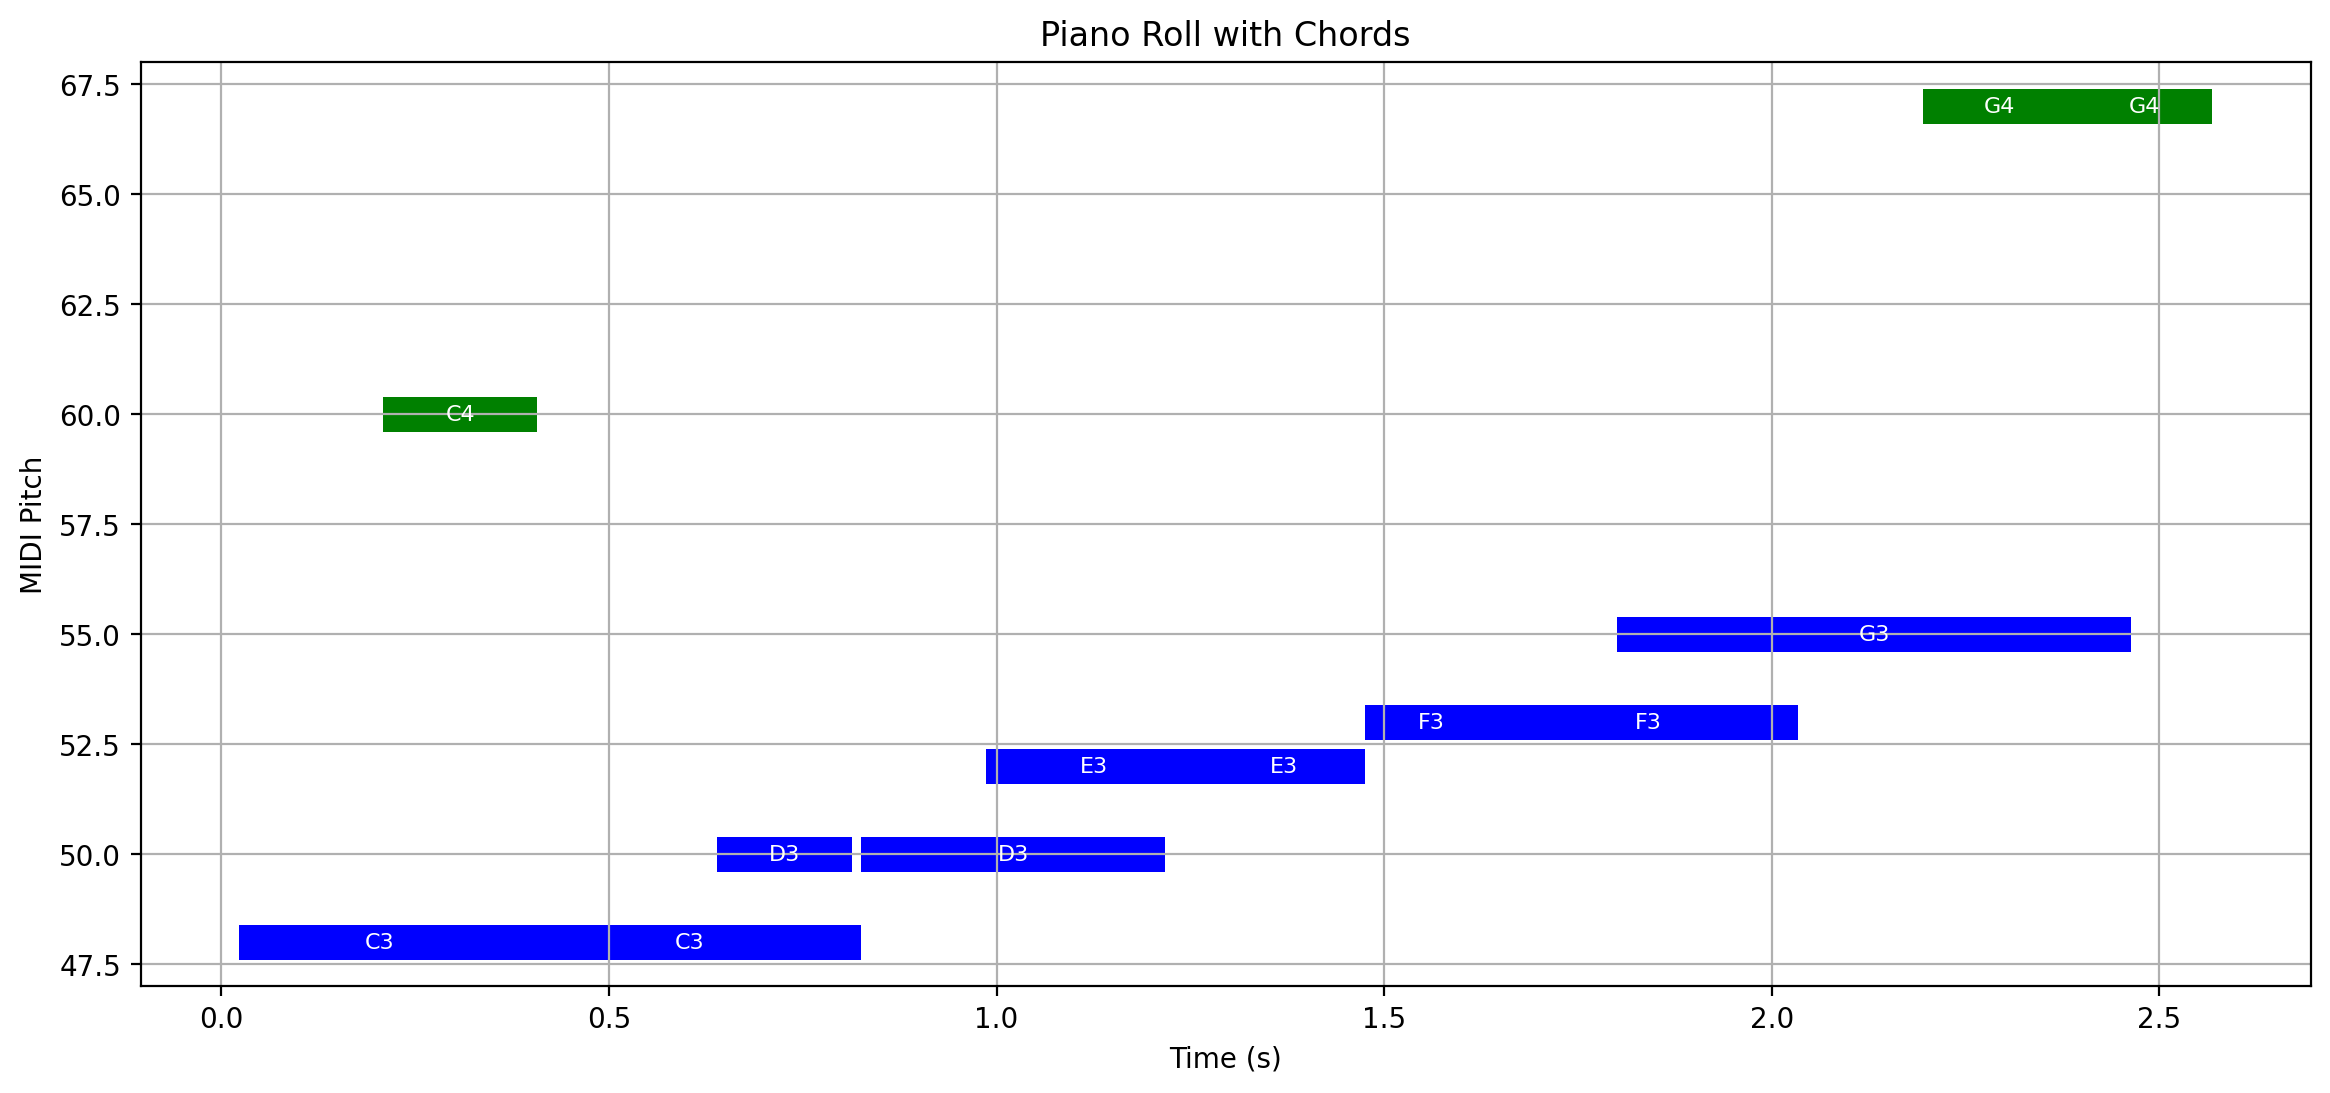

In [25]:
def plot_with_chords(df, title="Piano Roll with Chords"):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(14, 6))

    for _, note in df.iterrows():
        if note['is_chord']:
            color = 'red'
        else:
            color = 'blue' if note['hand'] == 'left' else 'green'
        ax.broken_barh(
            [(note['start'], note['duration'])],
            (note['pitch'] - 0.4, 0.8),
            facecolors=color
        )
        ax.text(
            note['start'] + note['duration'] / 2,
            note['pitch'],
            note['note_name'],
            color='white',
            ha='center',
            va='center',
            fontsize=8
        )

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("MIDI Pitch")
    ax.set_title(title)
    ax.set_ylim(df['pitch'].min() - 1, df['pitch'].max() + 1)
    ax.grid(True)
    plt.show()

plot_with_chords(df)


In [26]:
pip install music21


Note: you may need to restart the kernel to use updated packages.


In [27]:
from music21 import stream, note, midi

score = stream.Stream()

for _, row in df.iterrows():
    n = note.Note(row['note_name'])
    n.offset = row['start']
    n.quarterLength = row['duration']
    n.volume.velocity = row['velocity']
    score.append(n)

score.show('text')        # simple console preview
# score.show()            # opens in MuseScore / Finale if installed
# score.write('midi', fp='output/music21_export.mid')


{0.0} <music21.note.Note C>
{0.361} <music21.note.Note C>
{0.559} <music21.note.Note C>
{1.0} <music21.note.Note D>
{1.175} <music21.note.Note D>
{1.568} <music21.note.Note E>
{1.848} <music21.note.Note E>
{2.057} <music21.note.Note F>
{2.23} <music21.note.Note F>
{2.616} <music21.note.Note G>
{3.28} <music21.note.Note G>
{3.478} <music21.note.Note G>
